# Image Segmentation

* MNB Course on Image Processing, November 2018

Jan Eglinger

Friedrich Miescher Institute for Biomedical Research (FMI), Basel

![QR Code](images/segmentation-qr.png)
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/imagejan/image-processing-courses/segmentation?filepath=image-segmentation.ipynb)

## Basic concepts of image segmentation

This presentation aims at illustrating basic concepts of **image segmentation**.

In addition, it presents simple code examples using ImageJ2 for interested readers. Feel free to simply skip over the code if you're just interested in the concepts.

In [1]:
//load ImageJ
%classpath config resolver imagej.public https://maven.imagej.net/content/groups/public
%classpath add mvn net.imagej imagej 2.0.0-rc-68

//create ImageJ object
ij = new net.imagej.ImageJ()

notebook = ij.notebook()
datasetIO = ij.scifio().datasetIO()
ops = ij.op()
"ImageJ initialized"

Added new repo: imagej.public


ImageJ initialized

## What is segmentation?

Dividing your data into two (or more) partitions

## Image segmentation by thresholding

* By defining a threshold on our data, we can partition it into two groups

On an image, we can define our threshold on the **pixel intensities**:
* bright pixels will be considered foreground
* dark pixels will be considered background

For example, let's consider the (ideal) image of a spherical object:

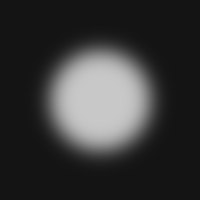

In [2]:
disk = ops.run("create.img", [200, 200])
disk = ops.run("convert.uint8", disk)

// fill entire image with value 20
newValue = disk.firstElement().copy()
newValue.setReal(20)
disk = ops.run("image.fill", disk, newValue)

// fill disk with value 200
import net.imglib2.Point
import net.imglib2.algorithm.region.hypersphere.HyperSphere

location = new Point(disk.numDimensions())
location.setPosition([100, 100] as long[])

hyperSphere = new HyperSphere(disk, location, 50)

for (value in hyperSphere) {
  value.setReal(200)
}

disk = ops.run("filter.gauss", disk, 10)
notebook.display(disk)

Now we can simply define a threshold somewhere between the brightest and the darkest intensity, which will divide our image into:
* foreground (white) and
* background (black):

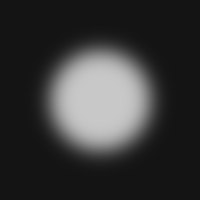

In [3]:
notebook.display(disk)

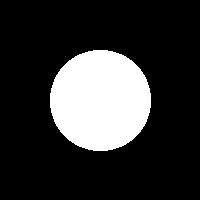

In [4]:
notebook.display(ops.run("threshold.otsu", disk))

In reality, images are never free of **noise**.

Let's add two versions of our object, with increasing levels of noise:

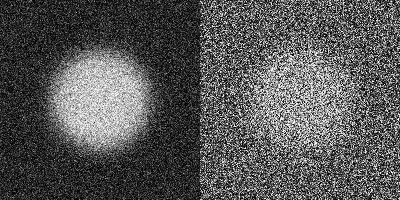

In [5]:

noiseOp1 = ops.op("addNoise", disk.firstElement(), 0, 255,  40)
noiseOp2 = ops.op("addNoise", disk.firstElement(), 0, 255, 120)

noisy1 = ops.run("copy.img", disk)
ops.run("map", noisy1, noiseOp1)
noisy2 = ops.run("copy.img", disk)
ops.run("map", noisy2, noiseOp2)
notebook.display(notebook.mosaic([3,1] as int[],
                 //disk,
                 noisy1,
                 noisy2)
                )


Now, we'll try to get a segmentation by creating a binary image using *Otsu* threshold on the pixel intensities:

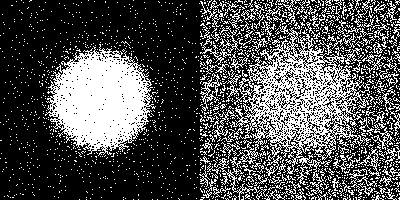

In [6]:
notebook.display(notebook.mosaic([2,1] as int[],
                                 ops.run("threshold.otsu", noisy1),
                                 ops.run("threshold.otsu", noisy2)
                                ))

The result isn't very satisfying. We need to do some **preprocessing** before segmentation.

## Filtering / Convolution


Let's filter our noisy image with a Gaussian kernel:


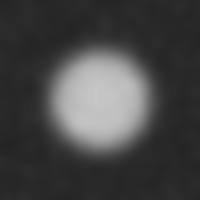

In [7]:
noisy1_blurred = ops.run("filter.gauss", noisy1, 5)
notebook.display(noisy1_blurred)

... and then binarize it with an *Otsu* threshold:


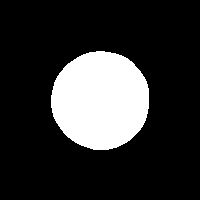

In [8]:
notebook.display(ops.run("threshold.otsu", noisy1_blurred))

The same with the even noisier image. A Gaussian convolution:


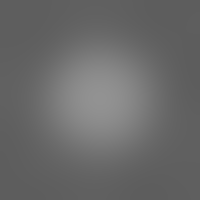

In [9]:
noisy2_blurred = ops.run("filter.gauss", noisy2, 20)
notebook.display(noisy2_blurred)

And a thresholding:

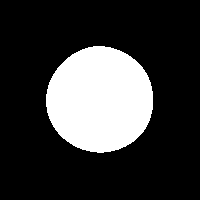

In [10]:
notebook.display(ops.run("threshold.otsu", noisy2_blurred))

Unfortunately, it isn't always as simple:

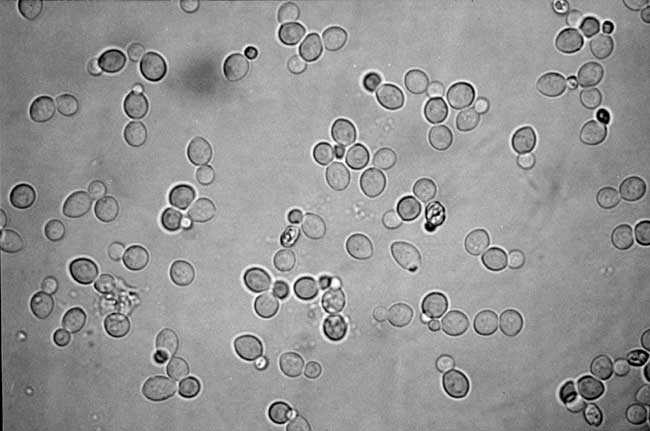

In [11]:
image = datasetIO.open("https://2.bp.blogspot.com/-uuoxxToW-o4/WRRaSRBRx2I/AAAAAAAAZVg/jV5tmaapBNUGUXvbv4p6h41JWuvYCakeQCEw/s1600/levedura.png")
image = ops.run("convert.float32", image)
notebook.display(image)

But also here, image filtering helps. In this case, we use a *Variance* filter:

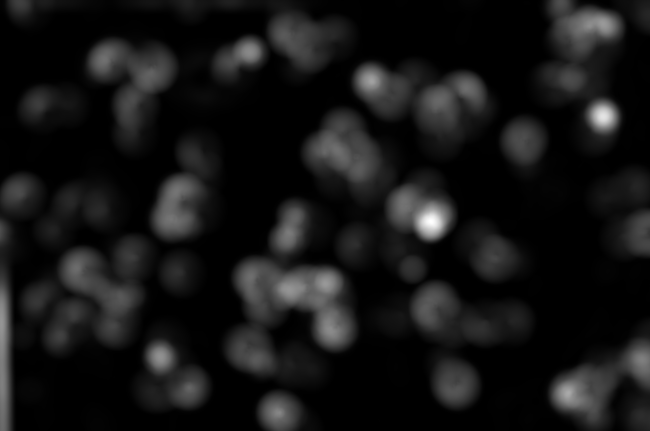

In [12]:
filtered = ops.run("copy.img", image)
import net.imglib2.algorithm.neighborhood.HyperSphereShape
filtered = ops.run("filter.variance", filtered, image, new HyperSphereShape(15))
notebook.display(filtered)

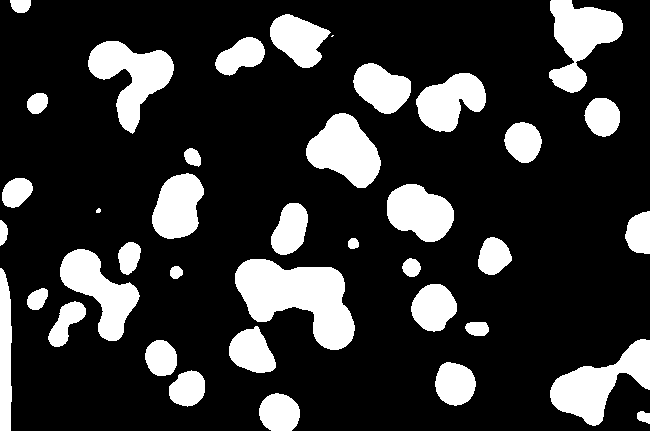

In [13]:
thresholded = ops.run("threshold.otsu", filtered)
notebook.display(thresholded)

## Connected-component analysis

Differentiating between foreground and background often is not enough. In most cases, we'd like to get an idea about the **objects** in our image.

* How many distinct objects (e.g. cells) are there?
* Can we get measurements (e.g. size, intensity) for each object

So we need to uniquely label all pixels that belong to a *single* connected object. We apply a **connected-component analysis**.

Each connected component of our image gets assigned a unique label (i.e. pixel intensity):

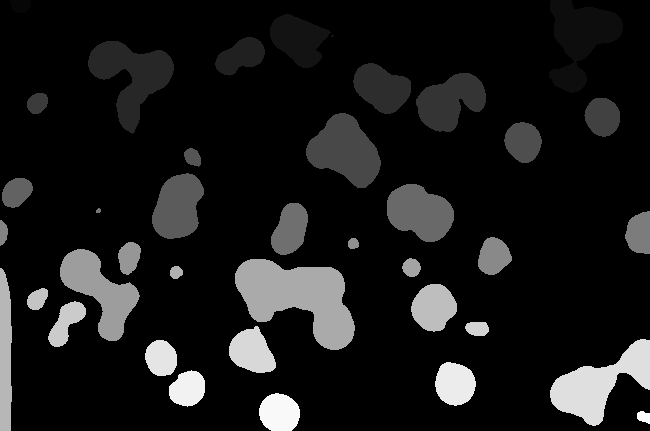

In [21]:
import net.imglib2.algorithm.labeling.ConnectedComponents.StructuringElement
labels = ops.run("cca", thresholded, StructuringElement.FOUR_CONNECTED)
indexImage = labels.getIndexImg()
notebook.display(indexImage)

## Watershed

When the number of objects is large, or they're highly clustered, a connected-component analysis will not yield the desired object labeling. Touching objects will be assigned the same label and therefore considered a single object.

A **watershed segmentation** helps to distinguish touching objects.

We'll have a look interactively with ImageJ's watershed implementation.


## Other segmentation methods

* Clustering
* Region growing
* Graph cut


## Resources

* https://imagej.net/Segmentation
* https://forum.image.sc
